In [18]:
import re
import unicodedata
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [19]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

In [20]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [21]:
df = pd.read_csv('./spam_clean.csv')
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [22]:
df.isnull().sum()

label    0
text     0
dtype: int64

# Exercises

## Create df looking at count and percent of spam and ham emails

In [26]:
df_len = df.assign(length = df.text.apply(len))

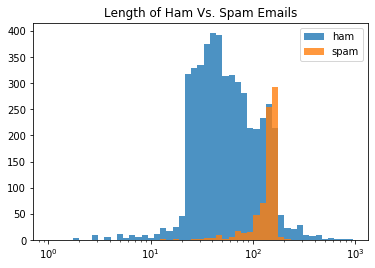

In [28]:
plt.xscale('log')
bins = 1.15**(np.arange(0,50))
plt.hist(df_len[df_len['label'] == 'ham']['length'], bins=bins, alpha=0.8)
plt.hist(df_len[df_len['label'] == 'spam']['length'], bins=bins, alpha=0.8)

plt.legend(('ham', 'spam'))
plt.title('Length of Ham Vs. Spam Emails')
plt.show()

In [ ]:
df_len

In [8]:
# number of different categories of emails

df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [9]:
# percent of different categories of emails

df.label.value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [10]:
# concatenate the two Series' into a df with cols n and percent

labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


## Clean subsets of df transformed into lists of words

In [28]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
ham_words[:5]

['go', 'jurong', 'point', 'crazy', 'available']

In [15]:
spam_words = clean(' '.join(df[df.label == 'spam'].text))

In [16]:
all_words = clean(' '.join(df.text))

## Transform lists of word subsets into pandas Series' to explore frequency of words in emails

In [24]:
ham_freq = pd.Series(ham_words).value_counts()
ham_freq.head()

im      449
get     314
go      273
ok      272
dont    257
dtype: int64

In [25]:
spam_freq = pd.Series(spam_words).value_counts()
spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [26]:
all_freq = pd.Series(all_words).value_counts()
all_freq.head()

call    600
im      462
get     397
ur      384
go      304
dtype: int64

## Combine three Series' together into a df

- concatenate the three Series' into a df


- set cols to all, ham, spam


- replace Null values with 0


- convert data types to int using a lambda function

In [40]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
 .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
 .fillna(0)
 .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


## Most frequently occuring words

In [41]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


## Explore words that are unique to spam and ham emails

In [53]:
# concatenate the two df tails into a single df

pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(10),
word_counts[word_counts.ham == 0].sort_values(by='spam').tail(10)])

,all,ham,spam
didnt,79,79,0
amp,82,82,0
said,86,86,0
ask,88,88,0
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0


## Visualize

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

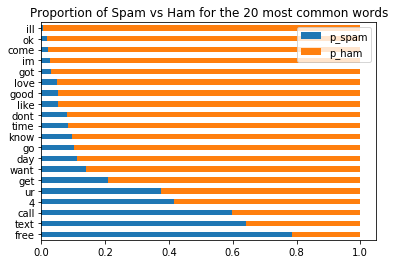

In [81]:
# figure out the percentage of spam vs. percentage of ham with some pretty complicated code
# .assign adds cols that are calculated from cols in an existing df and add the new calculated cols to the df
# .sort_values by all words
# use only new cols, p_spam and p_ham
# use only the last 20 cols and sort_values by p_ham 
# create a stacked horizontal bar plot

(
word_counts.assign(p_spam = word_counts.spam / word_counts['all'],
                   p_ham = word_counts.ham / word_counts['all'])
                   .sort_values(by='all')
                   [['p_spam', 'p_ham']]
                   .tail(20)
                   .sort_values('p_ham')
                   .plot.barh(stacked=True)
    
)
plt.title('Proportion of Spam vs Ham for the 20 most common words')
plt.show()

In [82]:
# get the ratio of use by word for for emails by spam to ham

(
word_counts[(word_counts.spam > 10) & (word_counts.ham > 10)]
            .assign(ratio=lambda df: df.spam / (df.ham + .01))
            .sort_values(by='ratio')
            .pipe(lambda df: pd.concat([df.head(), df.tail()]))
)

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


## Word Clouds Example

The wordcloud allows you to identify the relative frequency of different keywords using an easily digestible visual.


Common Use Cases


- As a visualization technique, this method gives a more qualitative analysis of the topics in the documents.


Pros


- It’s intuitive and easy to comprehend.


- It helps identify overall respondent sentiment and the specific factors that drive it.


- It provides direction for further analysis.


Cons


- It fails to measure each word’s value in and of itself.


- It allows irrelevant words to appear.


- When words appear similar in size, it becomes difficult to differentiate them.

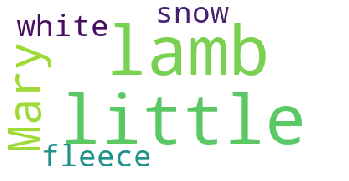

In [85]:
sentence = 'Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow.'

img = WordCloud(background_color='white').generate(sentence)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

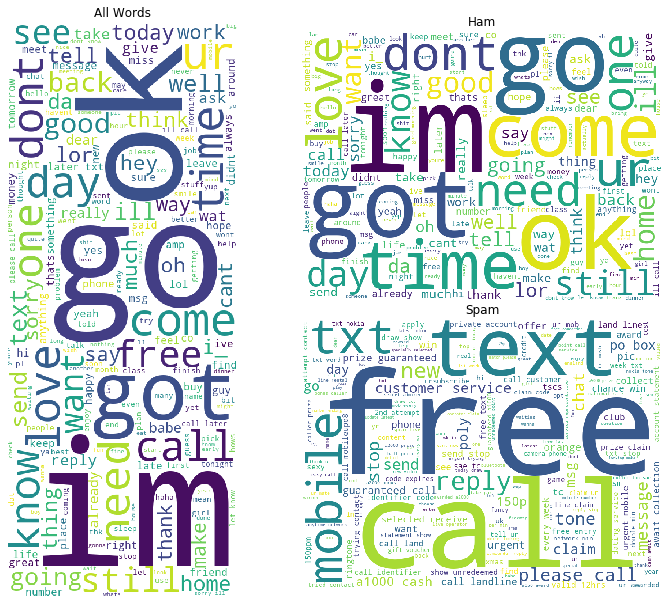

In [86]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

## Bigrams Examples

- Bigrams are a specific instance of the broader concept of n-grams, which is a way to combine words together. This lets us measure not just the individual word frequency, but also takes into account which words appear together.


- To produce the bigrams, we'll use nltk.

In [89]:
sentence = 'Mary had a little lamb'

bigrams = nltk.ngrams(sentence.split(), 2)
list(bigrams)

[('Mary', 'had'), ('had', 'a'), ('a', 'little'), ('little', 'lamb')]

In [102]:
# look at count ofham email bigrams

top_20_ham_bigrams = pd.Series(nltk.ngrams(ham_words, 2)).value_counts().head(20)
top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

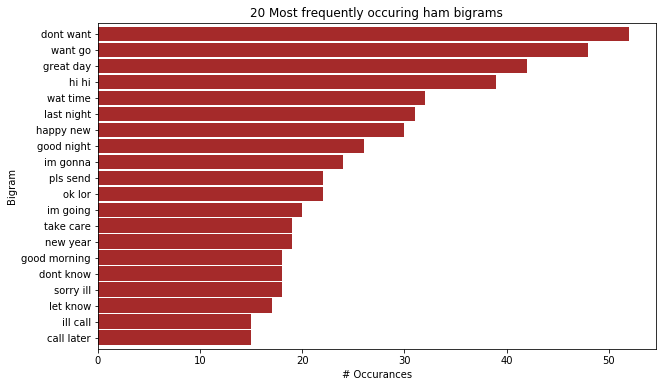

In [166]:
top_20_ham_bigrams.sort_values().plot.barh(color='brown', width=.9, figsize=(10,6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

plt.show()

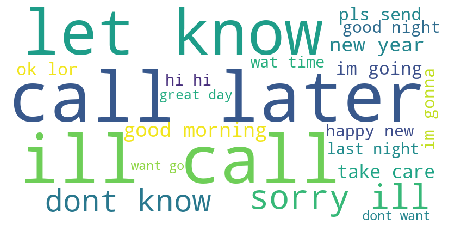

In [110]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

plt.show()

## Spam Data

- Load the spam data set.



- Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?



- Is there any overlap in the bigrams for the spam data and the ham data?



- Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

## Explore bigrams

In [111]:
# look at count ofham email bigrams

top_20_spam_bigrams = pd.Series(nltk.ngrams(spam_words, 2)).value_counts().head(20)
top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
dtype: int64

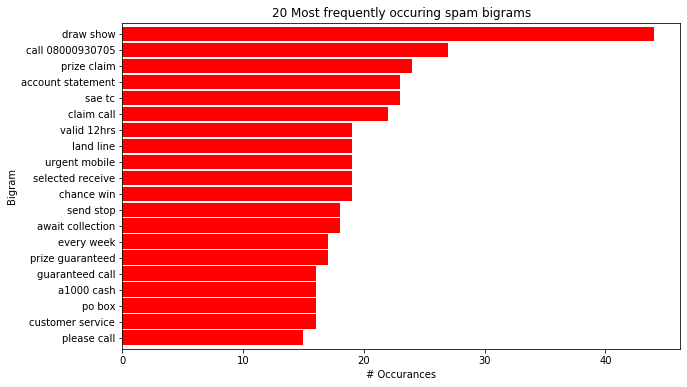

In [114]:
top_20_spam_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10,6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

plt.show()

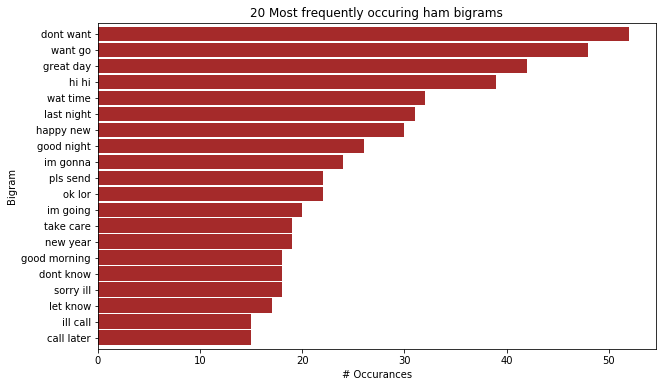

In [165]:
top_20_ham_bigrams.sort_values().plot.barh(color='brown', width=.9, figsize=(10,6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

plt.show()

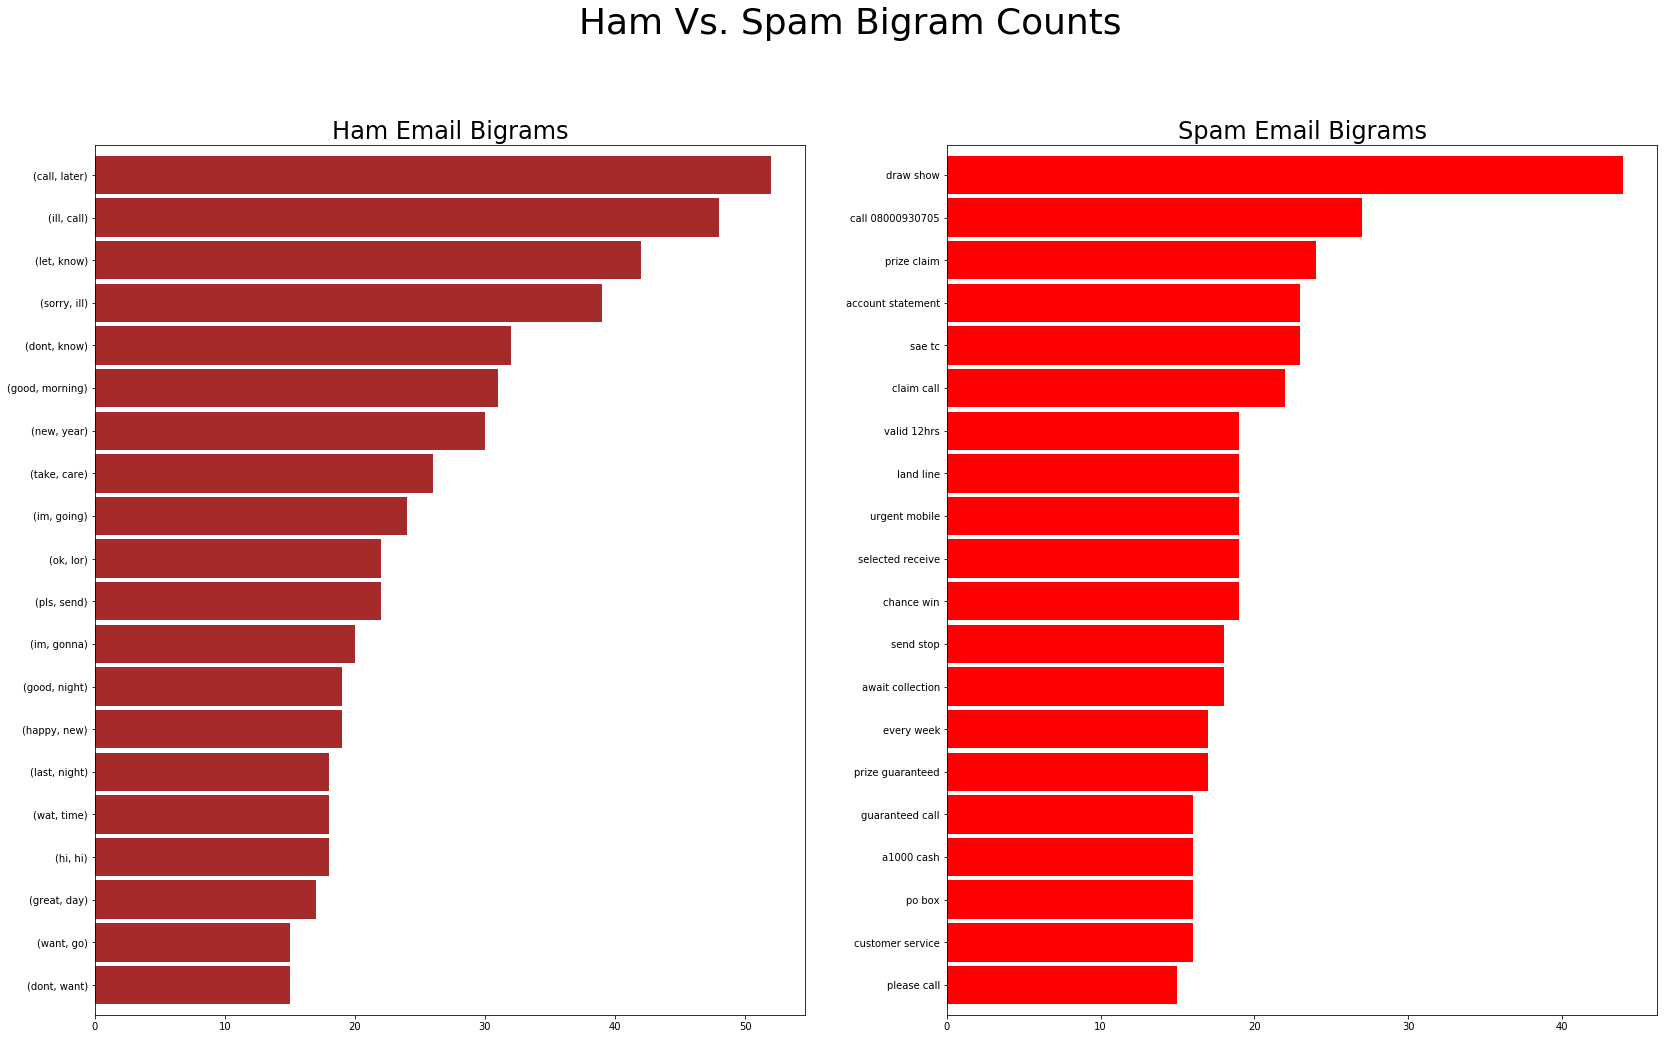

In [182]:
# create subplots
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28, 16))

# create horizontal barchart of ham bigrams
top_20_ham_bigrams.sort_values().plot(kind='barh', color='brown', width=.9, ax=ax)

# clean up ticks/bigrams not working here
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

# set title for ham email bigrams
ax.set_title('Ham Email Bigrams', fontsize=24)

# create horizontal barchart of spam bigrams
top_20_spam_bigrams.sort_values().plot(kind='barh',color='red', width=.9, ax=ax2)

# clean up ticks/bigrams not working here
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

# set title for spam email bigrams
ax2.set_title('Spam Email Bigrams', fontsize=24)

# set supertitle
plt.suptitle('Ham Vs. Spam Bigram Counts', fontsize=36, y=1)

plt.show()

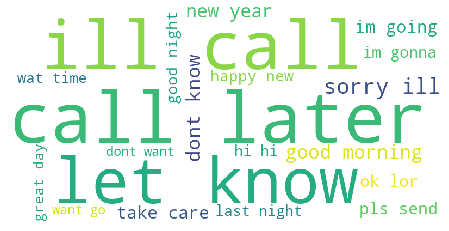

In [116]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

plt.show()

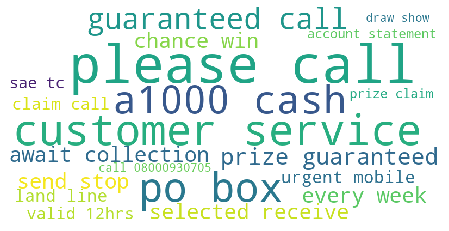

In [117]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

plt.show()

## Explore the blog articles using the techniques discussed in the exploration lesson.

## Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.